In [1]:
import collections
import functools
import statistics
from typing import Callable, Iterator, List, Optional, Tuple

import matplotlib.pyplot as plt
import nest_asyncio
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from plotnine import *
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate

# Table of Contents

- [Step 1](#Step-1)
- [Step 2](#Step-2-+-Step-3)
- [Step 3](#Step-2-+-Step-3)
 * [Substep: EDA](#Substep:-EDA)
- [Step 4](#Step-4)
- [Step 5](#Step-5)
- [Step 6](#Step-6)
- [Step 7](#Step-7)
- [Step 8](#Step-8)
- [Step 9](#Step-9)
- [Step 10](#Step-10)

In [2]:
def inspect_df(df: pd.DataFrame, n: int = 5) -> pd.DataFrame:
    """Helper method to easily inspect DataFrames."""

    print(f"shape: {df.shape}")

    return df.head(n)

In [3]:
# disclaimer: may not work as is in Windows OS
# dataset source: https://grouplens.org/datasets/movielens/
!wget --backups=1 https://files.grouplens.org/datasets/movielens/ml-latest-small.zip -P data/

--2022-03-29 21:02:06--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘data/ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K   251KB/s    in 3.8s    

2022-03-29 21:02:11 (251 KB/s) - ‘data/ml-latest-small.zip’ saved [978202/978202]



In [4]:
# disclaimer: may not work as is in Windows OS
# if `unzip` does not exist in your system: apt-get install unzip
!unzip -o data/ml-latest-small.zip -d data/

Archive:  data/ml-latest-small.zip
  inflating: data/ml-latest-small/links.csv  
  inflating: data/ml-latest-small/tags.csv  
  inflating: data/ml-latest-small/ratings.csv  
  inflating: data/ml-latest-small/README.txt  
  inflating: data/ml-latest-small/movies.csv  


## Step 1

The prediction $r_{ui}$ is set as:

$$ r_{ui} = \mu + b_u + b_i + q_{i}^T p_u$$

If user $u$ is unknown, then the bias $b_u$ and the factors $p_u$ are assumed to be zero. 

The same applies for item $i$ with $b_i$ and $q_i$.

To estimate all the unknown, we minimize the following regularized squared error:

$$ \sum_{r_{ui} \in R_{train}} (r_{ui} - \hat{r_{ui}})^2 + \lambda (b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2)$$

The minimization is performed by a stochastic gradient descent:

$$ b_u \leftarrow b_u + \gamma (e_{ui} - \lambda b_u)$$
$$ b_i \leftarrow b_i + \gamma (e_{ui} - \lambda b_i)$$
$$ p_u \leftarrow p_u + \gamma (e_{ui} q_i - \lambda p_u)$$
$$ q_i \leftarrow q_i + \gamma (e_{ui} p_u - \lambda q_i)$$

where: $e_{ui} = r_{ui} - \hat{r_{ui}}$, $\gamma$ is the learning rate and $\lambda$ the regularization term. These steps are performed over all the ratings of the trainset and repeated $n$ times, where $n$ is the number of epochs.

Baselines are initialized to zero. User and item factors are randomly initialized according to a normal distribution.

[reference](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)

## Step 2 + Step 3

In [5]:
reader = Reader(
    line_format="user item rating timestamp", sep=",", skip_lines=1, rating_scale=(1, 5)
)

In [6]:
data = Dataset.load_from_file("data/ml-latest-small/ratings.csv", reader=reader)

#### Substep: EDA

In [7]:
movielens = pd.read_csv(
    "data/ml-latest-small/ratings.csv",
    names=["user", "item", "rating", "timestamp"],
    skiprows=1,
)

inspect_df(movielens)

shape: (100836, 4)


,user,item,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [8]:
movielens[movielens["rating"].isin([0.5, 1.5, 2.5, 3.5, 4.5])]

,user,item,rating,timestamp
234,2,1704,4.5,1445715228
237,2,8798,3.5,1445714960
240,2,58559,4.5,1445715141
242,2,68157,4.5,1445715154
247,2,80489,4.5,1445715340
...,...,...,...,...
100820,610,160341,2.5,1479545749
100821,610,160527,4.5,1479544998
100826,610,162350,3.5,1493849971
100827,610,163937,3.5,1493848789


In [9]:
print(f"number of users: {len(movielens['user'].unique())}")

number of users: 610


In [10]:
print(f"number of items: {len(movielens['item'].unique())}")

number of items: 9724


In [11]:
movielens["created_at"] = pd.to_datetime(movielens["timestamp"], unit="s")
movielens["created_at"] = pd.to_datetime(movielens["created_at"], format="%Y-%m")

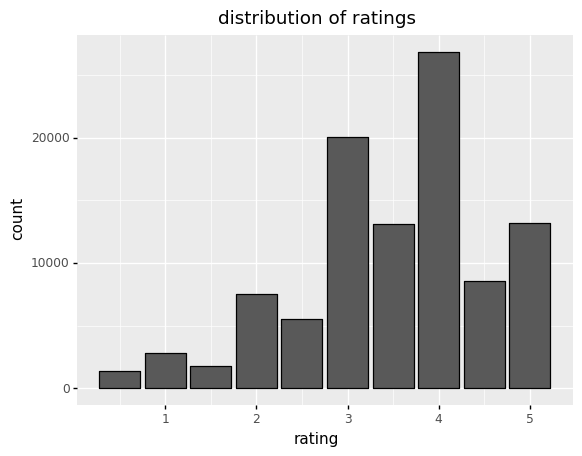

<ggplot: (8762571742970)>

In [12]:
(
    ggplot(movielens, aes(x="rating"))
    + geom_bar(color="black")
    + labs(x="rating", title="distribution of ratings")
)

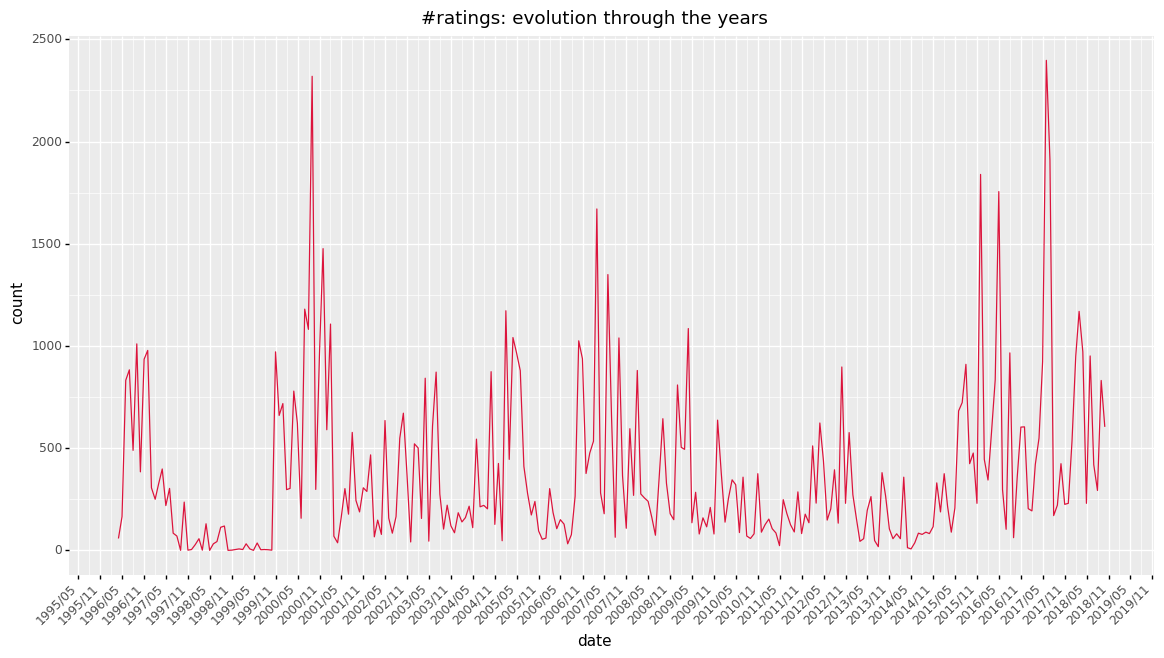

<ggplot: (8762457176456)>

In [13]:
(
    ggplot(
        movielens.groupby(pd.Grouper(key="created_at", freq="M")).count().reset_index()
    )
    + geom_line(aes(x="created_at", y="item"), color="crimson")
    + labs(x="date", y="count", title="#ratings: evolution through the years")
    + scale_x_datetime(breaks=date_breaks("6 months"), labels=date_format("%Y/%m"))
    + theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(14, 7))
)

## Step 4

In [14]:
recsys_small = SVD(
    n_factors=4,
    n_epochs=50,
    biased=True,  # use baselines
    random_state=123456,
)

In [15]:
recsys_large = SVD(
    n_factors=20,
    n_epochs=50,
    biased=True,  # use baselines
    random_state=123456,
)

In [16]:
cv_results = {}

cv_results["SVD w/ 4 factors"] = cross_validate(
    recsys_small,
    data=data,
    measures=["mse", "rmse", "mae"],
    return_train_measures=True,
    verbose=True,
    cv=5,
    n_jobs=-1,
)

Evaluating MSE, RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MSE (testset)     0.7715  0.7645  0.7685  0.7649  0.7764  0.7691  0.0044  
RMSE (testset)    0.8784  0.8744  0.8766  0.8746  0.8811  0.8770  0.0025  
MAE (testset)     0.6712  0.6688  0.6701  0.6696  0.6728  0.6705  0.0014  
MSE (trainset)    0.5137  0.5129  0.5106  0.5091  0.5194  0.5131  0.0035  
RMSE (trainset)   0.7167  0.7162  0.7145  0.7135  0.7207  0.7163  0.0025  
MAE (trainset)    0.5514  0.5510  0.5502  0.5487  0.5547  0.5512  0.0020  
Fit time          1.67    1.62    1.66    1.70    1.62    1.65    0.03    
Test time         0.09    0.10    0.10    0.11    0.13    0.11    0.01    


In [17]:
cv_results["SVD w/ 20 factors"] = cross_validate(
    recsys_large,
    data=data,
    measures=["mse", "rmse", "mae"],
    return_train_measures=True,
    verbose=True,
    cv=5,
    n_jobs=-1,
)

Evaluating MSE, RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MSE (testset)     0.7806  0.7788  0.7748  0.7971  0.7784  0.7819  0.0078  
RMSE (testset)    0.8835  0.8825  0.8803  0.8928  0.8823  0.8843  0.0044  
MAE (testset)     0.6743  0.6736  0.6732  0.6811  0.6762  0.6757  0.0029  
MSE (trainset)    0.3011  0.3012  0.3009  0.3019  0.3020  0.3014  0.0004  
RMSE (trainset)   0.5487  0.5488  0.5486  0.5494  0.5495  0.5490  0.0004  
MAE (trainset)    0.4226  0.4238  0.4229  0.4234  0.4234  0.4232  0.0004  
Fit time          3.65    3.68    3.64    3.44    3.58    3.60    0.09    
Test time         0.10    0.11    0.10    0.10    0.10    0.10    0.00    


In [18]:
df = pd.DataFrame(cv_results).T.reset_index()

df["mean RMSE (train)"] = df["train_rmse"].map(lambda x: statistics.mean(x))
df["mean RMSE (test)"] = df["test_rmse"].map(lambda x: statistics.mean(x))

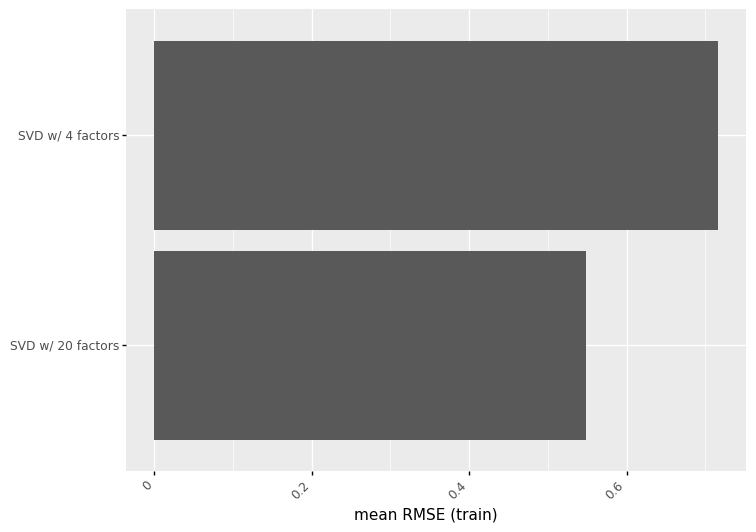

<ggplot: (8762450016509)>

In [19]:
(
    ggplot(df)
    + geom_col(aes(x="index", y="mean RMSE (train)"), stat="identity")
    + theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(8, 6))
    + labs(x="", y="mean RMSE (train)")
    + coord_flip()
)

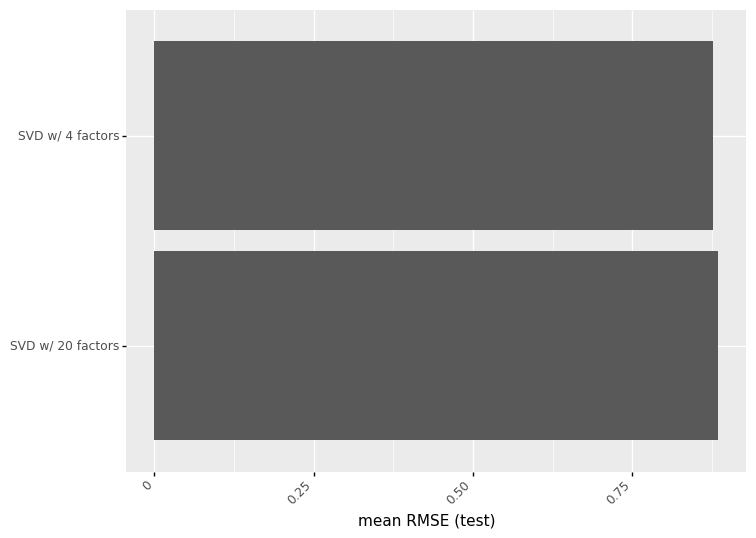

<ggplot: (8762562625271)>

In [20]:
(
    ggplot(df)
    + geom_col(aes(x="index", y="mean RMSE (test)"), stat="identity")
    + theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(8, 6))
    + labs(x="", y="mean RMSE (test)")
    + coord_flip()
)

## Step 5

In [21]:
ratings = pd.read_csv(
    "data/ml-latest-small/ratings.csv",
    usecols=["user", "item", "rating"],
    names=["user", "item", "rating"],
    skiprows=1,
)

inspect_df(ratings)

shape: (100836, 3)


,user,item,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [22]:
ratings["user"] = ratings.groupby("user").ngroup()

In [23]:
ratings["item"] = ratings.groupby("item").ngroup()

In [24]:
def transform_batch(batch: tf.Tensor) -> collections.OrderedDict:
    return collections.OrderedDict(
        x=tf.cast(batch[:, 0:2], tf.int64), y=tf.cast(batch[:, 2:3], tf.float32)
    )

In [25]:
def create_tf_datasets(
    data: pd.DataFrame,
    transform_func: Callable,
    batch_size: int = 1,
    max_clients: int = None,
    max_items_per_client: int = None,
) -> Iterator[tf.data.Dataset]:

    n_users = len(data["user"].unique())

    if max_clients is not None:
        n_users = min(n_users, max_clients)

    for _, user_ratings in data.groupby("user"):

        if n_users < 0:
            break

        tf_dataset = tf.data.Dataset.from_tensor_slices(user_ratings)

        yield (
            tf_dataset.take(max_items_per_client)
            .shuffle(buffer_size=max_items_per_client, seed=42)
            .batch(batch_size)
            .map(transform_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        )

        n_users -= 1

In [26]:
def split_tf_datasets(
    tf_datasets: List[tf.data.Dataset],
    train_fraction: float = 0.8,
) -> Tuple[List[tf.data.Dataset], List[tf.data.Dataset]]:
    """Splits a list of user TF datasets into train/test by user."""
    np.random.seed(42)
    np.random.shuffle(tf_datasets)

    train_idx = int(len(tf_datasets) * train_fraction)

    # Note that the test data contains completely different users, not
    # just unseen ratings from train users.
    return (
        tf_datasets[:train_idx],
        tf_datasets[train_idx:],
    )

In [27]:
tf_datasets = [
    *create_tf_datasets(
        data=ratings,
        transform_func=transform_batch,
        batch_size=10,
        max_clients=100,
        max_items_per_client=3000,
    )
]

In [28]:
tf_trainsets, tf_testsets = split_tf_datasets(tf_datasets, train_fraction=0.8)

## Step 6

In [29]:
nest_asyncio.apply()

In [30]:
n_users = len(ratings["user"].unique())
n_items = len(ratings["item"].unique())

In [31]:
def matrix_factorization_model(
    n_users: int,
    n_items: int,
    n_latent_factors: int,
) -> tf.keras.Model:
    """A federation-friendly Matrix Factorization model."""
    combined_input = tf.keras.layers.Input(
        shape=[2], dtype="int32", name="combined_input"
    )
    u = tf.keras.layers.Embedding(
        input_dim=n_users + 1, output_dim=n_latent_factors, name="users_embedding"
    )(combined_input[:, 0])
    u = tf.keras.layers.Flatten()(u)

    i = tf.keras.layers.Embedding(
        input_dim=n_items + 1, output_dim=n_latent_factors, name="items_embedding"
    )(combined_input[:, 1])
    i = tf.keras.layers.Flatten()(i)

    output = tf.output_layer = tf.keras.layers.Dot(1, normalize=False, name="Dot")(
        [i, u]
    )

    model = tf.keras.Model(inputs=combined_input, outputs=output)

    input_spec = collections.OrderedDict(
        x=tf.TensorSpec(shape=[None, 2], dtype=tf.int64),
        y=tf.TensorSpec(shape=[None, 1], dtype=tf.float32),
    )

    return tff.learning.from_keras_model(
        model,
        input_spec=input_spec,
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )

In [32]:
model_fn = functools.partial(
    matrix_factorization_model,
    n_users=n_users,
    n_items=n_items,
    n_latent_factors=4,
)

In [33]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0),
)

In [34]:
print(iterative_process.initialize.type_signature.formatted_representation())

( -> <
  model=<
    trainable=<
      float32[9725,4],
      float32[611,4]
    >,
    non_trainable=<>
  >,
  optimizer_state=<
    int64
  >,
  delta_aggregate_state=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  model_broadcast_state=<>
>@SERVER)


In [35]:
state = iterative_process.initialize()

print(state.model)

ModelWeights(trainable=[array([[-0.02781699,  0.04236168,  0.0195894 ,  0.02565583],
       [ 0.03135501,  0.01275723, -0.03948408, -0.03784215],
       [-0.03500485, -0.04342555, -0.00115202,  0.03705515],
       ...,
       [-0.02960833,  0.04715235,  0.0184778 , -0.01748275],
       [-0.04920484, -0.02791704,  0.00798515,  0.02341176],
       [-0.02652301,  0.04371275, -0.0241725 , -0.0207178 ]],
      dtype=float32), array([[-0.04854823,  0.02279918,  0.02544511,  0.02868749],
       [-0.00305455, -0.03421041,  0.00190018,  0.01567392],
       [-0.00100468, -0.00790118,  0.00982042,  0.00268791],
       ...,
       [ 0.0327472 , -0.02517691,  0.0263097 , -0.01952354],
       [ 0.01922908, -0.02282287, -0.02886724, -0.02991344],
       [ 0.03334575,  0.0067232 ,  0.01447457, -0.02382979]],
      dtype=float32)], non_trainable=[])


In [36]:
print("User variables shape:", state.model.trainable[1].shape)

User variables shape: (611, 4)


In [37]:
print("Item variables shape:", state.model.trainable[0].shape)

Item variables shape: (9725, 4)


In [38]:
evaluation_computation = tff.learning.build_federated_evaluation(model_fn)

In [39]:
print(evaluation_computation.type_signature.formatted_representation())

(<
  server_model_weights=<
    trainable=<
      float32[9725,4],
      float32[611,4]
    >,
    non_trainable=<>
  >@SERVER,
  federated_dataset={<
    x=int64[?,2],
    y=float32[?,1]
  >*}@CLIENTS
> -> <
  eval=<
    root_mean_squared_error=float32,
    loss=float32,
    num_examples=int64,
    num_batches=int64
  >
>@SERVER)


In [40]:
NUM_ROUNDS = 200  # we will set up a training loop to train over multiple rounds.

In [41]:
train_losses, train_accs = [], []

state = iterative_process.initialize()

for i in range(NUM_ROUNDS):
    federated_train_data = np.random.choice(
        tf_trainsets, size=50, replace=False
    ).tolist()
    state, metrics = iterative_process.next(state, federated_train_data)
    print(f"Train round {i}:", metrics["train"])
    train_losses.append(metrics["train"]["loss"])
    train_accs.append(metrics["train"]["root_mean_squared_error"])

Train round 0: OrderedDict([('root_mean_squared_error', 3.6591754), ('loss', 13.3895645), ('num_examples', 8644), ('num_batches', 888)])
Train round 1: OrderedDict([('root_mean_squared_error', 3.620398), ('loss', 13.107283), ('num_examples', 8908), ('num_batches', 917)])
Train round 2: OrderedDict([('root_mean_squared_error', 3.6475768), ('loss', 13.304816), ('num_examples', 9100), ('num_batches', 932)])
Train round 3: OrderedDict([('root_mean_squared_error', 3.692861), ('loss', 13.637223), ('num_examples', 7853), ('num_batches', 811)])
Train round 4: OrderedDict([('root_mean_squared_error', 3.622406), ('loss', 13.121827), ('num_examples', 9232), ('num_batches', 947)])
Train round 5: OrderedDict([('root_mean_squared_error', 3.6823072), ('loss', 13.559387), ('num_examples', 8628), ('num_batches', 887)])
Train round 6: OrderedDict([('root_mean_squared_error', 3.714812), ('loss', 13.799829), ('num_examples', 9198), ('num_batches', 943)])
Train round 7: OrderedDict([('root_mean_squared_err

Train round 60: OrderedDict([('root_mean_squared_error', 3.6495628), ('loss', 13.319308), ('num_examples', 8618), ('num_batches', 884)])
Train round 61: OrderedDict([('root_mean_squared_error', 3.763515), ('loss', 14.164046), ('num_examples', 8117), ('num_batches', 836)])
Train round 62: OrderedDict([('root_mean_squared_error', 3.7083135), ('loss', 13.75159), ('num_examples', 8083), ('num_batches', 831)])
Train round 63: OrderedDict([('root_mean_squared_error', 3.6867616), ('loss', 13.592211), ('num_examples', 7246), ('num_batches', 750)])
Train round 64: OrderedDict([('root_mean_squared_error', 3.6572616), ('loss', 13.375564), ('num_examples', 9553), ('num_batches', 979)])
Train round 65: OrderedDict([('root_mean_squared_error', 3.6375558), ('loss', 13.231812), ('num_examples', 8580), ('num_batches', 883)])
Train round 66: OrderedDict([('root_mean_squared_error', 3.6889067), ('loss', 13.608032), ('num_examples', 7509), ('num_batches', 773)])
Train round 67: OrderedDict([('root_mean_sq

Train round 120: OrderedDict([('root_mean_squared_error', 3.5991993), ('loss', 12.954235), ('num_examples', 6714), ('num_batches', 697)])
Train round 121: OrderedDict([('root_mean_squared_error', 3.4245148), ('loss', 11.727302), ('num_examples', 7966), ('num_batches', 819)])
Train round 122: OrderedDict([('root_mean_squared_error', 3.4612741), ('loss', 11.980418), ('num_examples', 7438), ('num_batches', 768)])
Train round 123: OrderedDict([('root_mean_squared_error', 3.2561393), ('loss', 10.602444), ('num_examples', 8850), ('num_batches', 910)])
Train round 124: OrderedDict([('root_mean_squared_error', 3.2566586), ('loss', 10.605825), ('num_examples', 9814), ('num_batches', 1005)])
Train round 125: OrderedDict([('root_mean_squared_error', 3.4947686), ('loss', 12.213408), ('num_examples', 8583), ('num_batches', 882)])
Train round 126: OrderedDict([('root_mean_squared_error', 3.2236016), ('loss', 10.391607), ('num_examples', 9440), ('num_batches', 967)])
Train round 127: OrderedDict([('r

2022-03-29 21:08:30.741727: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 141: OrderedDict([('root_mean_squared_error', 3.4539835), ('loss', 11.930002), ('num_examples', 7123), ('num_batches', 736)])
Train round 142: OrderedDict([('root_mean_squared_error', 3.2595046), ('loss', 10.624371), ('num_examples', 7594), ('num_batches', 783)])
Train round 143: OrderedDict([('root_mean_squared_error', 3.3224647), ('loss', 11.038772), ('num_examples', 7867), ('num_batches', 812)])
Train round 144: OrderedDict([('root_mean_squared_error', 3.2905416), ('loss', 10.827664), ('num_examples', 6985), ('num_batches', 722)])
Train round 145: OrderedDict([('root_mean_squared_error', 3.2272284), ('loss', 10.415004), ('num_examples', 9292), ('num_batches', 952)])
Train round 146: OrderedDict([('root_mean_squared_error', 3.0940323), ('loss', 9.573036), ('num_examples', 8417), ('num_batches', 863)])
Train round 147: OrderedDict([('root_mean_squared_error', 3.0159194), ('loss', 9.09577), ('num_examples', 9616), ('num_batches', 986)])
Train round 148: OrderedDict([('root_

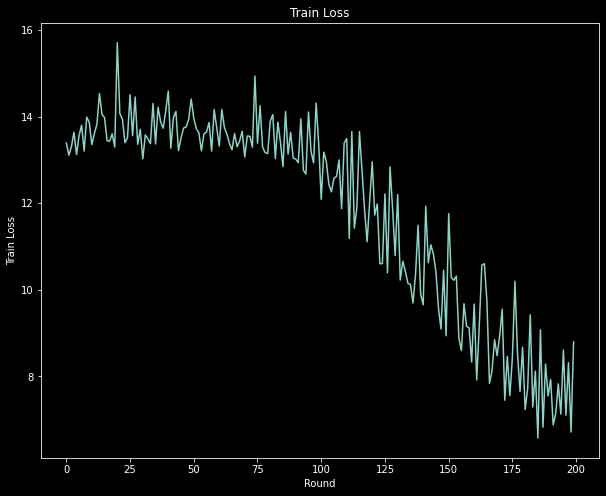

In [42]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = [10, 8]
plt.plot(range(NUM_ROUNDS), train_losses)
plt.ylabel("Train Loss")
plt.xlabel("Round")
plt.title("Train Loss")
plt.show()

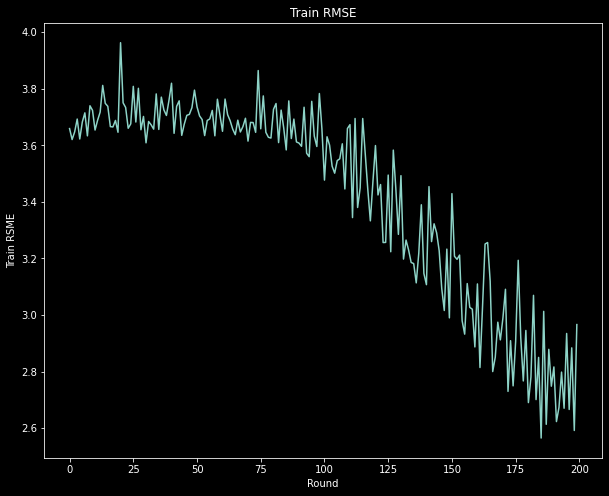

In [43]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = [10, 8]
plt.plot(range(NUM_ROUNDS), train_accs)
plt.ylabel("Train RSME")
plt.xlabel("Round")
plt.title("Train RMSE")
plt.show()

In [45]:
eval_metrics = evaluation_computation(state.model, tf_testsets)
print("Final Test:", eval_metrics["eval"])

Final Test: OrderedDict([('root_mean_squared_error', 3.784521), ('loss', 14.3226), ('num_examples', 2339), ('num_batches', 240)])


## Step 7

In [46]:
model_fn = functools.partial(
    matrix_factorization_model,
    n_users=n_users,
    n_items=n_items,
    n_latent_factors=4,
)

In [47]:
fedprox_learning_process = tff.learning.algorithms.build_unweighted_fed_prox(
    model_fn,
    proximal_strength=0.15,
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(1.0),
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(0.5),
)

/home/iantonopoulos/.cache/pypoetry/virtualenvs/recommender-systems-rVb3Y5Fg-py3.8/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("PartitionedCall:5", shape=(None,), dtype=int32), values=Tensor("PartitionedCall:4", shape=(None, 4), dtype=float32), dense_shape=Tensor("PartitionedCall:6", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
/home/iantonopoulos/.cache/pypoetry/virtualenvs/recommender-systems-rVb3Y5Fg-py3.8/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("PartitionedCall:2", shape=(None,), dtype=int32), values=Tensor("PartitionedCall:1", shape=(None, 4), dtype=float32), dense_shape=Tensor("PartitionedCall:3", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.


In [48]:
print(fedprox_learning_process.initialize.type_signature.formatted_representation())

( -> <
  global_model_weights=<
    trainable=<
      float32[9725,4],
      float32[611,4]
    >,
    non_trainable=<>
  >,
  distributor=<>,
  client_work=<>,
  aggregator=<
    <>,
    <>
  >,
  finalizer=<
    int64
  >
>@SERVER)


In [49]:
evaluation_computation = tff.learning.build_federated_evaluation(
    model_fn,
)

In [50]:
print(evaluation_computation.type_signature.formatted_representation())

(<
  server_model_weights=<
    trainable=<
      float32[9725,4],
      float32[611,4]
    >,
    non_trainable=<>
  >@SERVER,
  federated_dataset={<
    x=int64[?,2],
    y=float32[?,1]
  >*}@CLIENTS
> -> <
  eval=<
    root_mean_squared_error=float32,
    loss=float32,
    num_examples=int64,
    num_batches=int64
  >
>@SERVER)


In [51]:
train_losses, train_rmses = [], []

state = fedprox_learning_process.initialize()

# This may take a couple minutes to run.
for i in range(NUM_ROUNDS):
    federated_train_data = np.random.choice(
        tf_trainsets, size=50, replace=False
    ).tolist()
    next_state = fedprox_learning_process.next(state, federated_train_data)
    train_losses.append(next_state.metrics["client_work"]["train"]["loss"])
    train_rmses.append(
        next_state.metrics["client_work"]["train"]["root_mean_squared_error"]
    )

model_final_weights = next_state.state.global_model_weights

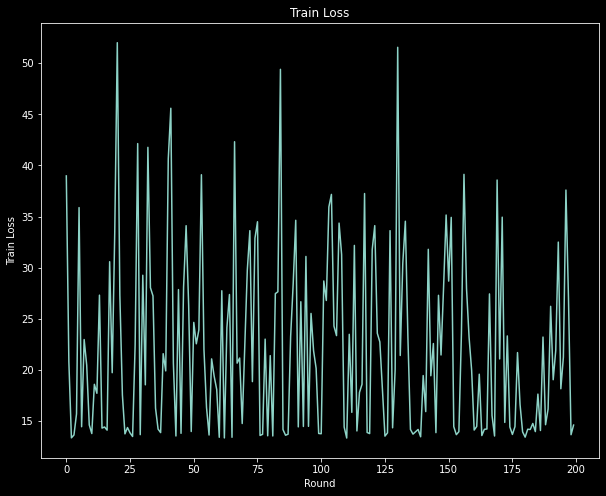

In [52]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = [10, 8]
plt.plot(range(NUM_ROUNDS), train_losses)
plt.ylabel("Train Loss")
plt.xlabel("Round")
plt.title("Train Loss")
plt.show()

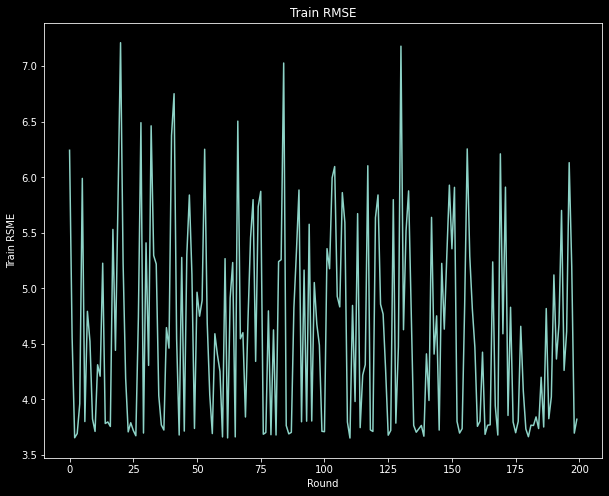

In [53]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = [10, 8]
plt.plot(range(NUM_ROUNDS), train_rmses)
plt.ylabel("Train RSME")
plt.xlabel("Round")
plt.title("Train RMSE")
plt.show()

In [55]:
eval_metrics = evaluation_computation(model_final_weights, tf_testsets)
print("Final Test:", eval_metrics["eval"])

Final Test: OrderedDict([('root_mean_squared_error', 3.7630253), ('loss', 14.16036), ('num_examples', 2339), ('num_batches', 240)])


## Step 8

In [56]:
def transform_batch_for_fed_recon(batch: tf.Tensor) -> collections.OrderedDict:
    """we do not need the user since each client will only look at their own data."""
    return collections.OrderedDict(
        x=tf.cast(batch[:, 1:2], tf.int64), y=tf.cast(batch[:, 2:3], tf.float32)
    )

In [57]:
tf_datasets = [
    *create_tf_datasets(
        data=ratings,
        transform_func=transform_batch_for_fed_recon,
        batch_size=10,
        max_clients=100,
        max_items_per_client=3000,
    )
]

In [59]:
tf_trainsets, tf_testsets = split_tf_datasets(
    tf_datasets,
    train_fraction=0.8,
)

In [60]:
class UserEmbedding(tf.keras.layers.Layer):
    """Keras layer representing an embedding for a single user."""

    def __init__(self, num_latent_factors, **kwargs):
        super().__init__(**kwargs)
        self.num_latent_factors = num_latent_factors

    def build(self, input_shape):
        self.embedding = self.add_weight(
            shape=(1, self.num_latent_factors),
            initializer="uniform",
            dtype=tf.float32,
            name="UserEmbeddingKernel",
        )
        super().build(input_shape)

    def call(self, inputs):
        return self.embedding

    def compute_output_shape(self):
        return (1, self.num_latent_factors)

In [61]:
def get_matrix_factorization_reconstruction_model(
    n_items: int, n_latent_factors: int
) -> tff.learning.reconstruction.Model:
    """Defines a Keras matrix factorization model."""
    # layers with variables will be partitioned into global and local layers.
    global_layers = []
    local_layers = []

    item_input = tf.keras.layers.Input(shape=[1], name="Item")
    item_embedding_layer = tf.keras.layers.Embedding(
        n_items, n_latent_factors, name="ItemEmbedding"
    )
    global_layers.append(item_embedding_layer)
    flat_item_vec = tf.keras.layers.Flatten(name="FlattenItems")(
        item_embedding_layer(item_input)
    )

    user_embedding_layer = UserEmbedding(n_latent_factors, name="UserEmbedding")
    local_layers.append(user_embedding_layer)

    flat_user_vec = user_embedding_layer(item_input)

    pred = tf.keras.layers.Dot(1, normalize=False, name="Dot")(
        [flat_user_vec, flat_item_vec]
    )

    input_spec = collections.OrderedDict(
        x=tf.TensorSpec(shape=[None, 1], dtype=tf.int64),
        y=tf.TensorSpec(shape=[None, 1], dtype=tf.float32),
    )

    model = tf.keras.Model(inputs=item_input, outputs=pred)

    return tff.learning.reconstruction.from_keras_model(
        keras_model=model,
        global_layers=global_layers,
        local_layers=local_layers,
        input_spec=input_spec,
    )

In [62]:
model_fn = functools.partial(
    get_matrix_factorization_reconstruction_model, n_items=n_items, n_latent_factors=4
)

In [63]:
class RatingAccuracy(tf.keras.metrics.Mean):
    """Keras metric computing accuracy of reconstructed ratings."""

    def __init__(self, name: str = "rating_accuracy", **kwargs):
        super().__init__(name=name, **kwargs)

    def update_state(
        self,
        y_true: tf.Tensor,
        y_pred: tf.Tensor,
        sample_weight: Optional[tf.Tensor] = None,
    ):
        absolute_diffs = tf.abs(y_true - y_pred)
        # A [batch_size, 1] tf.bool tensor indicating correctness within the
        # threshold for each example in a batch. A 0.5 threshold corresponds
        # to correctness when predictions are rounded to the nearest whole
        # number.
        example_accuracies = tf.less_equal(absolute_diffs, 0.5)
        super().update_state(example_accuracies, sample_weight=sample_weight)

In [64]:
loss_fn = lambda: tf.keras.losses.MeanSquaredError()
metrics_fn = lambda: [RatingAccuracy(), tf.keras.metrics.RootMeanSquaredError()]

In [65]:
training_process = tff.learning.reconstruction.build_training_process(
    model_fn=model_fn,
    loss_fn=loss_fn,
    metrics_fn=metrics_fn,
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(1.0),
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(0.5),
    reconstruction_optimizer_fn=lambda: tf.keras.optimizers.SGD(0.1),
)

In [66]:
print(training_process.initialize.type_signature.formatted_representation())

( -> <
  model=<
    trainable=<
      float32[9724,4]
    >,
    non_trainable=<>
  >,
  optimizer_state=<
    int64
  >,
  delta_aggregate_state=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  model_broadcast_state=<>
>@SERVER)


In [67]:
evaluation_computation = tff.learning.reconstruction.build_federated_evaluation(
    model_fn,
    loss_fn=loss_fn,
    metrics_fn=metrics_fn,
    reconstruction_optimizer_fn=functools.partial(tf.keras.optimizers.SGD, 0.1),
)

In [68]:
print(evaluation_computation.type_signature.formatted_representation())

(<
  server_model_weights=<
    trainable=<
      float32[9724,4]
    >,
    non_trainable=<>
  >@SERVER,
  federated_dataset={<
    x=int64[?,1],
    y=float32[?,1]
  >*}@CLIENTS
> -> <
  broadcast=<>,
  eval=<
    loss=float32,
    rating_accuracy=float32,
    root_mean_squared_error=float32
  >
>@SERVER)


In [69]:
state = training_process.initialize()

print(state.model)

ModelWeights(trainable=[array([[ 4.0288005e-02,  2.0956840e-02, -1.9867826e-02,  2.2228930e-02],
       [-3.5339318e-02,  3.0609395e-02, -5.3165667e-03, -3.1444132e-02],
       [-2.3192121e-02, -3.5728715e-02, -2.5840580e-02, -9.7503513e-04],
       ...,
       [ 3.3608686e-02,  4.9722757e-02,  2.3877028e-02, -4.0201496e-02],
       [-4.9091447e-02, -3.3627022e-02,  2.8727327e-02,  1.2706965e-05],
       [ 1.2091208e-02, -7.0439465e-03, -4.2397704e-02, -2.8338283e-04]],
      dtype=float32)], non_trainable=[])


In [70]:
print("Item variables shape:", state.model.trainable[0].shape)

Item variables shape: (9724, 4)


In [71]:
train_losses, train_accs, train_rmses = [], [], []

state = training_process.initialize()

# This may take a couple minutes to run.
for i in range(NUM_ROUNDS):
    federated_train_data = np.random.choice(
        tf_trainsets, size=50, replace=False
    ).tolist()
    state, metrics = training_process.next(state, federated_train_data)
    print(f"Train round {i}:", metrics["train"])
    train_losses.append(metrics["train"]["loss"])
    train_accs.append(metrics["train"]["rating_accuracy"])
    train_rmses.append(metrics["train"]["root_mean_squared_error"])

2022-03-29 21:23:54.485713: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 0: OrderedDict([('rating_accuracy', 0.006085193), ('root_mean_squared_error', 3.6605506), ('loss', 13.399631)])
Train round 1: OrderedDict([('rating_accuracy', 0.004564984), ('root_mean_squared_error', 3.7252543), ('loss', 13.87752)])
Train round 2: OrderedDict([('rating_accuracy', 0.0076512867), ('root_mean_squared_error', 3.6823177), ('loss', 13.559464)])
Train round 3: OrderedDict([('rating_accuracy', 0.004702194), ('root_mean_squared_error', 3.6934378), ('loss', 13.641483)])
Train round 4: OrderedDict([('rating_accuracy', 0.0056461734), ('root_mean_squared_error', 3.7230682), ('loss', 13.861238)])
Train round 5: OrderedDict([('rating_accuracy', 0.00860802), ('root_mean_squared_error', 3.6527104), ('loss', 13.342294)])
Train round 6: OrderedDict([('rating_accuracy', 0.012394645), ('root_mean_squared_error', 3.6915567), ('loss', 13.627591)])
Train round 7: OrderedDict([('rating_accuracy', 0.010972569), ('root_mean_squared_error', 3.6878555), ('loss', 13.600278)])
Train ro

2022-03-29 21:25:00.189647: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 22: OrderedDict([('rating_accuracy', 0.23508137), ('root_mean_squared_error', 1.8189734), ('loss', 3.308664)])
Train round 23: OrderedDict([('rating_accuracy', 0.24358974), ('root_mean_squared_error', 1.8491899), ('loss', 3.4195032)])
Train round 24: OrderedDict([('rating_accuracy', 0.26122707), ('root_mean_squared_error', 1.8176175), ('loss', 3.3037336)])
Train round 25: OrderedDict([('rating_accuracy', 0.22098936), ('root_mean_squared_error', 1.827685), ('loss', 3.3404324)])
Train round 26: OrderedDict([('rating_accuracy', 0.24704699), ('root_mean_squared_error', 1.7925919), ('loss', 3.213386)])
Train round 27: OrderedDict([('rating_accuracy', 0.29328248), ('root_mean_squared_error', 1.6615276), ('loss', 2.7606742)])
Train round 28: OrderedDict([('rating_accuracy', 0.28237563), ('root_mean_squared_error', 1.7067047), ('loss', 2.9128413)])
Train round 29: OrderedDict([('rating_accuracy', 0.20659554), ('root_mean_squared_error', 1.8078784), ('loss', 3.2684243)])
Train round

2022-03-29 21:26:52.550545: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 59: OrderedDict([('rating_accuracy', 0.34205472), ('root_mean_squared_error', 1.3748524), ('loss', 1.8902192)])
Train round 60: OrderedDict([('rating_accuracy', 0.33587036), ('root_mean_squared_error', 1.3920367), ('loss', 1.9377662)])
Train round 61: OrderedDict([('rating_accuracy', 0.30040836), ('root_mean_squared_error', 1.4460138), ('loss', 2.0909557)])
Train round 62: OrderedDict([('rating_accuracy', 0.4046397), ('root_mean_squared_error', 1.2679431), ('loss', 1.6076798)])
Train round 63: OrderedDict([('rating_accuracy', 0.3569405), ('root_mean_squared_error', 1.3301284), ('loss', 1.7692417)])
Train round 64: OrderedDict([('rating_accuracy', 0.31547478), ('root_mean_squared_error', 1.4101855), ('loss', 1.988623)])


2022-03-29 21:27:09.797759: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 65: OrderedDict([('rating_accuracy', 0.3667519), ('root_mean_squared_error', 1.3893745), ('loss', 1.9303616)])
Train round 66: OrderedDict([('rating_accuracy', 0.37658802), ('root_mean_squared_error', 1.2791098), ('loss', 1.6361221)])
Train round 67: OrderedDict([('rating_accuracy', 0.35765123), ('root_mean_squared_error', 1.3014312), ('loss', 1.6937233)])
Train round 68: OrderedDict([('rating_accuracy', 0.38899297), ('root_mean_squared_error', 1.2930962), ('loss', 1.6720978)])
Train round 69: OrderedDict([('rating_accuracy', 0.34115613), ('root_mean_squared_error', 1.3604174), ('loss', 1.8507354)])
Train round 70: OrderedDict([('rating_accuracy', 0.36589405), ('root_mean_squared_error', 1.3011202), ('loss', 1.6929138)])
Train round 71: OrderedDict([('rating_accuracy', 0.33724412), ('root_mean_squared_error', 1.3834279), ('loss', 1.9138728)])
Train round 72: OrderedDict([('rating_accuracy', 0.41675326), ('root_mean_squared_error', 1.2339281), ('loss', 1.5225785)])
Train rou

2022-03-29 21:28:05.113738: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 83: OrderedDict([('rating_accuracy', 0.38777718), ('root_mean_squared_error', 1.3790746), ('loss', 1.9018468)])
Train round 84: OrderedDict([('rating_accuracy', 0.43315393), ('root_mean_squared_error', 1.2133979), ('loss', 1.4723344)])
Train round 85: OrderedDict([('rating_accuracy', 0.41533756), ('root_mean_squared_error', 1.2262651), ('loss', 1.503726)])
Train round 86: OrderedDict([('rating_accuracy', 0.3950067), ('root_mean_squared_error', 1.1870041), ('loss', 1.4089787)])
Train round 87: OrderedDict([('rating_accuracy', 0.36201417), ('root_mean_squared_error', 1.2921532), ('loss', 1.66966)])
Train round 88: OrderedDict([('rating_accuracy', 0.42269662), ('root_mean_squared_error', 1.2166167), ('loss', 1.4801564)])
Train round 89: OrderedDict([('rating_accuracy', 0.35649124), ('root_mean_squared_error', 1.2458956), ('loss', 1.5522559)])
Train round 90: OrderedDict([('rating_accuracy', 0.3946601), ('root_mean_squared_error', 1.2210984), ('loss', 1.4910814)])
Train round 9

2022-03-29 21:29:38.536202: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 111: OrderedDict([('rating_accuracy', 0.39413202), ('root_mean_squared_error', 1.2019175), ('loss', 1.444606)])
Train round 112: OrderedDict([('rating_accuracy', 0.4052678), ('root_mean_squared_error', 1.1339754), ('loss', 1.2859002)])
Train round 113: OrderedDict([('rating_accuracy', 0.43933868), ('root_mean_squared_error', 1.188982), ('loss', 1.4136782)])
Train round 114: OrderedDict([('rating_accuracy', 0.4390356), ('root_mean_squared_error', 1.1600227), ('loss', 1.3456529)])
Train round 115: OrderedDict([('rating_accuracy', 0.45846543), ('root_mean_squared_error', 1.0737339), ('loss', 1.1529045)])
Train round 116: OrderedDict([('rating_accuracy', 0.43887362), ('root_mean_squared_error', 1.1425589), ('loss', 1.305441)])


2022-03-29 21:29:58.915102: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 117: OrderedDict([('rating_accuracy', 0.40066963), ('root_mean_squared_error', 1.2563134), ('loss', 1.5783234)])
Train round 118: OrderedDict([('rating_accuracy', 0.4194821), ('root_mean_squared_error', 1.1977832), ('loss', 1.4346846)])
Train round 119: OrderedDict([('rating_accuracy', 0.47434658), ('root_mean_squared_error', 1.0628791), ('loss', 1.129712)])
Train round 120: OrderedDict([('rating_accuracy', 0.42929563), ('root_mean_squared_error', 1.1847539), ('loss', 1.4036417)])
Train round 121: OrderedDict([('rating_accuracy', 0.46915478), ('root_mean_squared_error', 1.1199987), ('loss', 1.2543973)])
Train round 122: OrderedDict([('rating_accuracy', 0.41834083), ('root_mean_squared_error', 1.1475614), ('loss', 1.3168974)])
Train round 123: OrderedDict([('rating_accuracy', 0.48252743), ('root_mean_squared_error', 1.0594107), ('loss', 1.1223508)])
Train round 124: OrderedDict([('rating_accuracy', 0.40734223), ('root_mean_squared_error', 1.1814126), ('loss', 1.3957359)])
Tr

2022-03-29 21:31:12.356359: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 138: OrderedDict([('rating_accuracy', 0.46350044), ('root_mean_squared_error', 1.0738465), ('loss', 1.1531463)])
Train round 139: OrderedDict([('rating_accuracy', 0.48399547), ('root_mean_squared_error', 1.1113368), ('loss', 1.2350698)])
Train round 140: OrderedDict([('rating_accuracy', 0.49804577), ('root_mean_squared_error', 1.0109868), ('loss', 1.0220944)])
Train round 141: OrderedDict([('rating_accuracy', 0.4587474), ('root_mean_squared_error', 1.0841241), ('loss', 1.175325)])
Train round 142: OrderedDict([('rating_accuracy', 0.4799136), ('root_mean_squared_error', 1.0663277), ('loss', 1.1370548)])
Train round 143: OrderedDict([('rating_accuracy', 0.4105445), ('root_mean_squared_error', 1.2261732), ('loss', 1.5035007)])
Train round 144: OrderedDict([('rating_accuracy', 0.4164777), ('root_mean_squared_error', 1.1286389), ('loss', 1.2738259)])
Train round 145: OrderedDict([('rating_accuracy', 0.41819552), ('root_mean_squared_error', 1.1285778), ('loss', 1.2736881)])
Train

2022-03-29 21:34:38.899307: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 199: OrderedDict([('rating_accuracy', 0.56441957), ('root_mean_squared_error', 0.90743667), ('loss', 0.82344127)])


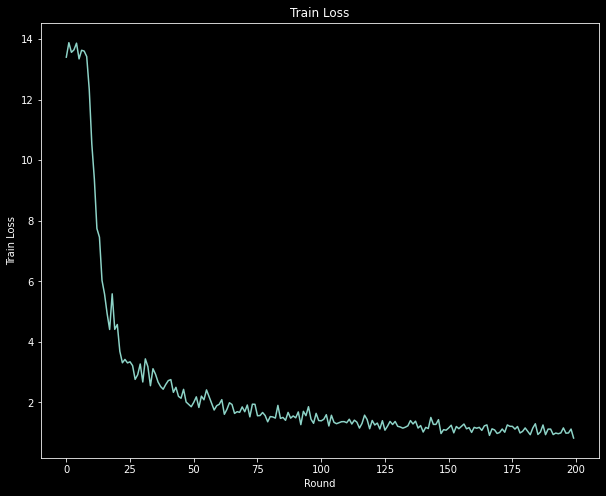

In [72]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = [10, 8]
plt.plot(range(NUM_ROUNDS), train_losses)
plt.ylabel("Train Loss")
plt.xlabel("Round")
plt.title("Train Loss")
plt.show()

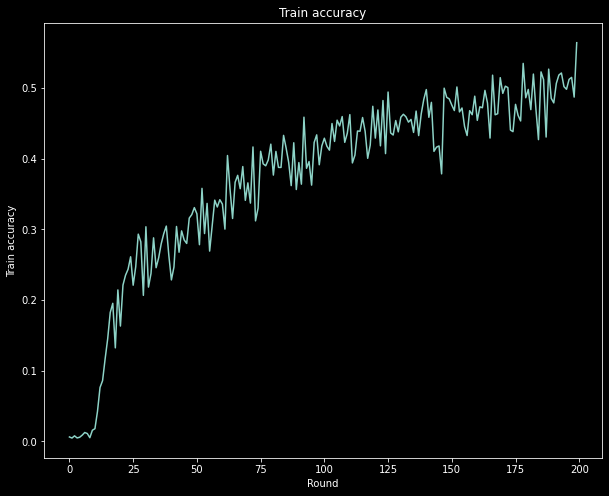

In [73]:
plt.plot(range(NUM_ROUNDS), train_accs)
plt.ylabel("Train accuracy")
plt.xlabel("Round")
plt.title("Train accuracy")
plt.show()

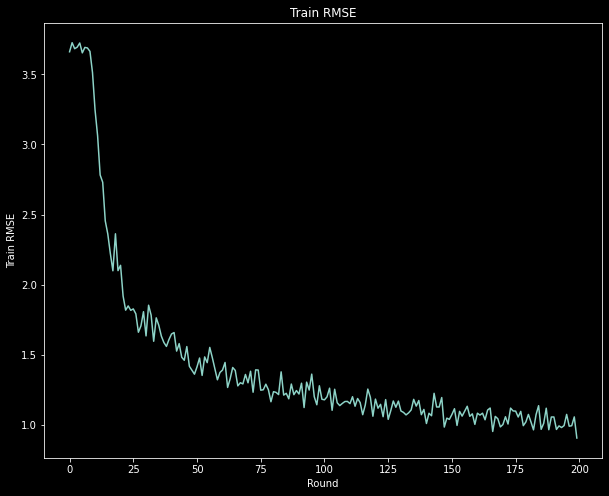

In [74]:
plt.plot(range(NUM_ROUNDS), train_rmses)
plt.ylabel("Train RMSE")
plt.xlabel("Round")
plt.title("Train RMSE")
plt.show()

In [75]:
eval_metrics = evaluation_computation(state.model, tf_testsets)
print("Final Test:", eval_metrics["eval"])

2022-03-29 21:36:12.002090: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Final Test: OrderedDict([('loss', 3.7958145), ('rating_accuracy', 0.20349762), ('root_mean_squared_error', 1.948285)])


## Step 9

In [81]:
# already incorporated in previous steps

## Step 10

In [82]:
# report